### Projet MLOps: Prédiction des défauts de prêts personnels (Banque XXX)

1. Objectif
- Compréhension des taux de défaut élévés sur les prêts personnels dans notre clientèle (particuliers) 
- Estimer la probabilité de défaut sur les prêts personnels pour chaque client en fonction de ses caractéristiques

2. Etapes
- Utilisation d'un dataset `Loan_Data` pour entraîner deux modèles : la **régression logistique** et **RandomForest**. Les modèles seront suivis avec **MLflow**, un outil pour le déploiement et la gestion des projets de machine learning  et nous allons comparer leurs performances.
- Chargement des données, pré-traitement, entraînement des modèles, analyse de données. Nous déploierons ensuite nos résultats en utilisant Flask, plateforme dédiée au déploiement des applications Python.

**I. Configurations préliminaires et pré-traitement des données**

1) Import des libraires nécessaires 

In [1]:
pip install fsspec

Note: you may need to restart the kernel to use updated packages.


In [2]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression  # Importer LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

2) Préparation des ressources MLFlow

In [3]:
# Création du serveur MLflow
!mlflow server --host 127.0.0.1 --port 8080

^C


3) Chargement des données

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Chargement des données
data = pd.read_csv(r"C:\Users\marin\Downloads\Loan_Data.csv")

# Visualisation des premières lignes du dataset
data.head()

# Prétraitement des données
X = data[['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score']]
y = data['default']

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

4. Exploration préliminaire des données

Premières lignes du dataset:
   customer_id  credit_lines_outstanding  loan_amt_outstanding  \
0      8153374                         0           5221.545193   
1      7442532                         5           1958.928726   
2      2256073                         0           3363.009259   
3      4885975                         0           4766.648001   
4      4700614                         1           1345.827718   

   total_debt_outstanding       income  years_employed  fico_score  default  
0             3915.471226  78039.38546               5         605        0  
1             8228.752520  26648.43525               2         572        1  
2             2027.830850  65866.71246               4         602        0  
3             2501.730397  74356.88347               5         612        0  
4             1768.826187  23448.32631               6         631        0  

Infos du dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns

<Figure size 1200x1000 with 0 Axes>

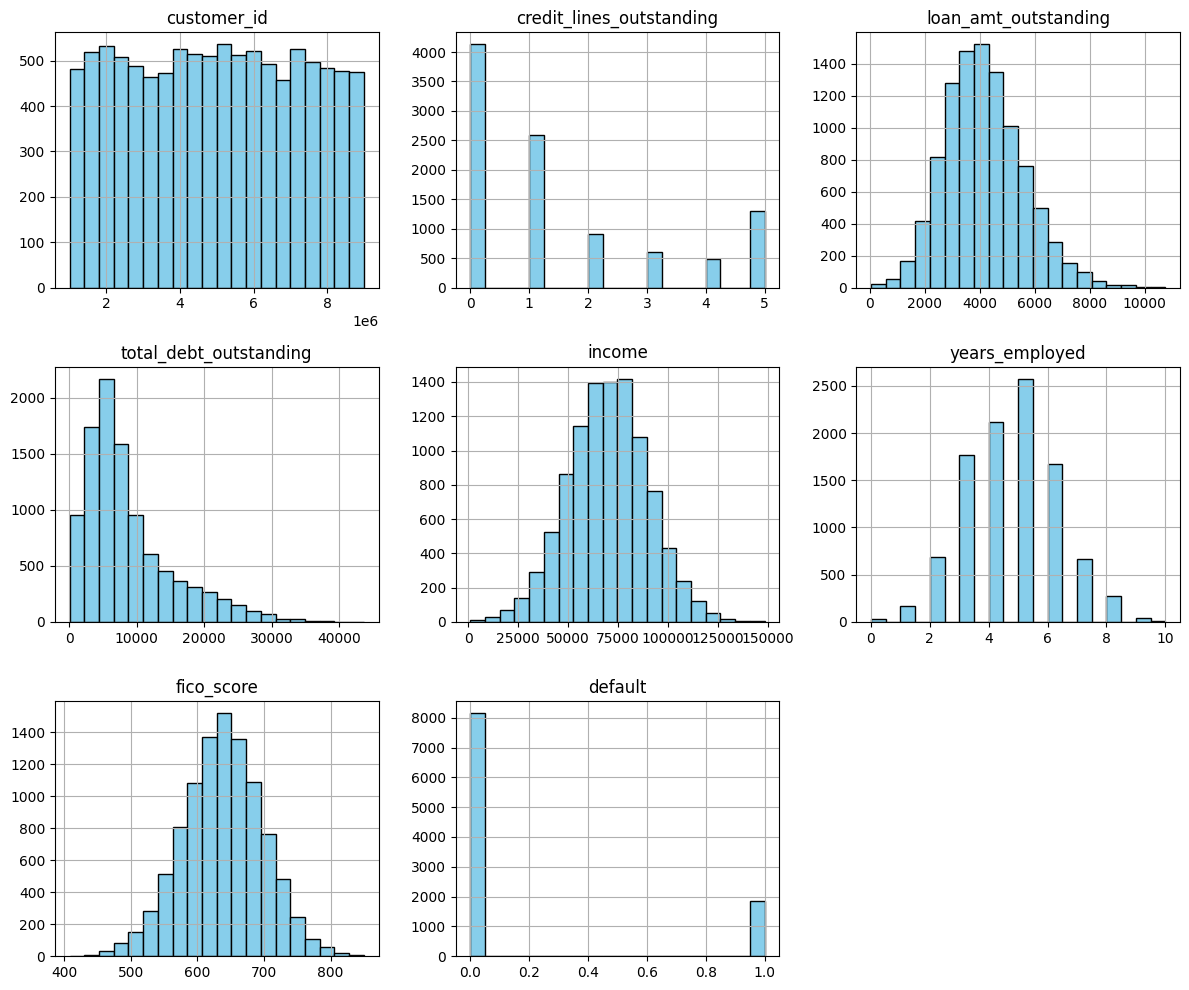

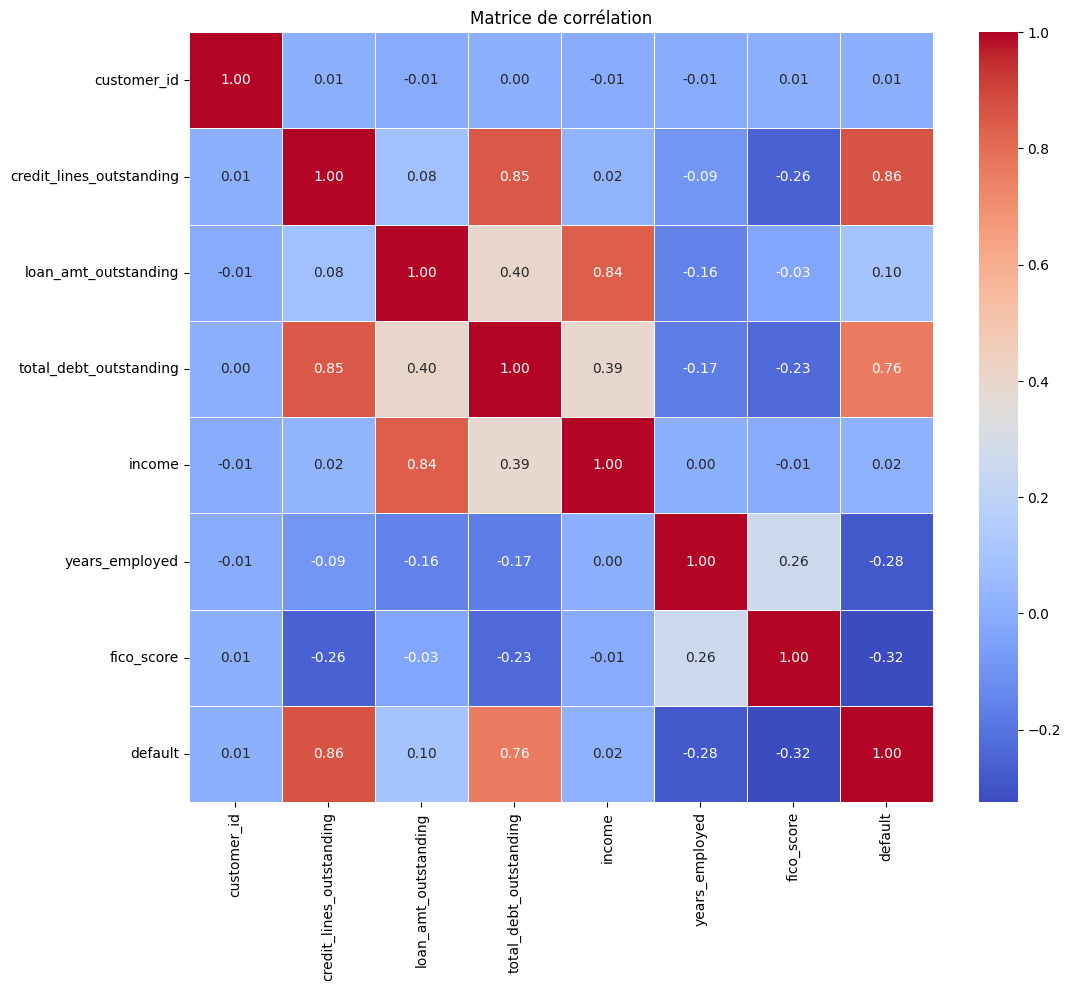

C:\Users\marin\AppData\Local\Temp\ipykernel_23960\2189064137.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='default', y='fico_score', data=data, palette='Set2')


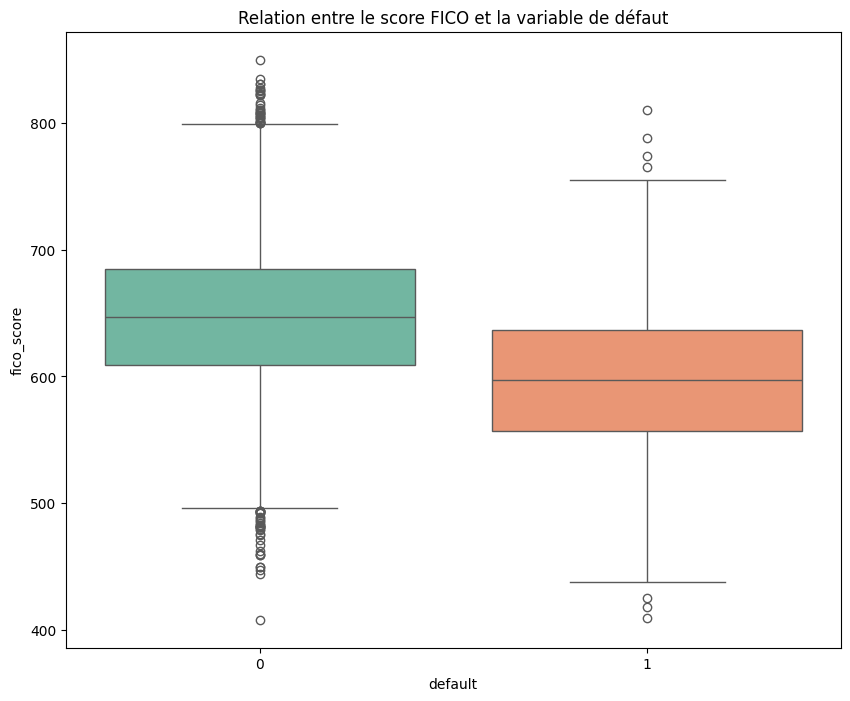

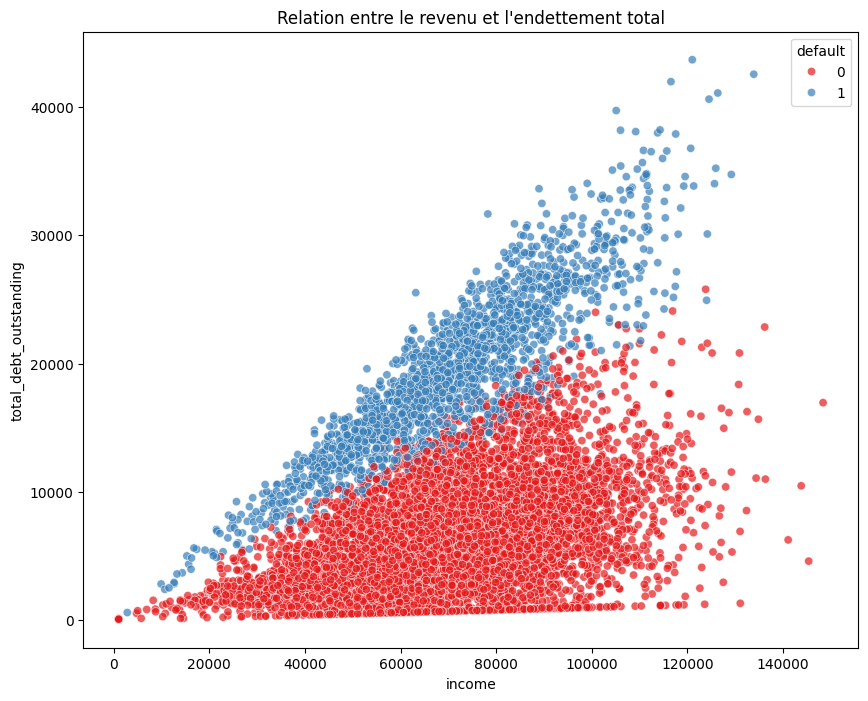

C:\Users\marin\AppData\Local\Temp\ipykernel_23960\2189064137.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='default', y='years_employed', data=data, palette='Set2')


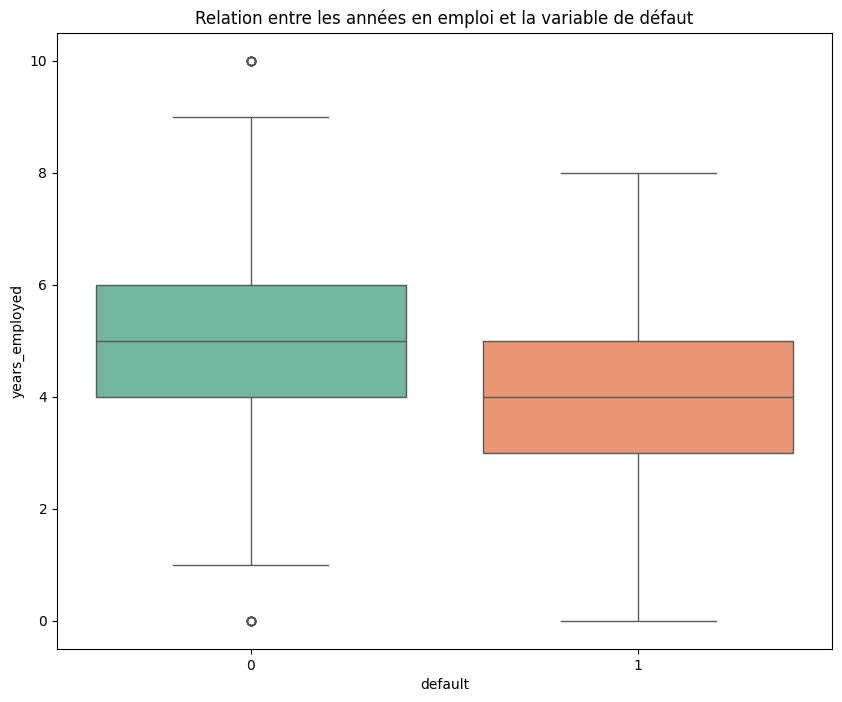

In [5]:
# Affichage des premières lignes du dataset
print("Premières lignes du dataset:")
print(data.head())

# Vérification des types de données et des valeurs manquantes
print("\nInfos du dataset:")
print(data.info())
print("\nValeurs manquantes par colonne:")
print(data.isnull().sum())

# Distribution de chaque variable numérique
plt.figure(figsize=(12, 10))
data.hist(bins=20, figsize=(12, 10), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.savefig("data_histograms.png")
plt.show()

# Visualisation de la matrice de corrélation
plt.figure(figsize=(12, 10))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation')
plt.savefig("correlation_matrix.png")
plt.show()

# Relation entre le score FICO et la variable "default"
plt.figure(figsize=(10, 8))
sns.boxplot(x='default', y='fico_score', data=data, palette='Set2')
plt.title('Relation entre le score FICO et la variable de défaut')
plt.savefig("fico_score_vs_default.png")
plt.show()

# Scatter plot pour visualiser la relation entre l'endettement total et le revenu
plt.figure(figsize=(10, 8))
sns.scatterplot(x='income', y='total_debt_outstanding', hue='default', data=data, palette='Set1', alpha=0.7)
plt.title('Relation entre le revenu et l\'endettement total')
plt.savefig("income_vs_debt.png")
plt.show()

# Scatter plot pour visualiser la relation entre l'ancienneté  total et la variable de défaut
plt.figure(figsize=(10, 8))
sns.boxplot(x='default', y='years_employed', data=data, palette='Set2')
plt.title('Relation entre les années en emploi et la variable de défaut')
plt.savefig("years_employed_vs_default.png")
plt.show()

*Méthode et interprétation :* <br>
Nous réalisons une première exploration des données, pour visualiser les variables corrélées et faire une première analyse des prédicteurs du risque de défaut des emprunteurs. 

| **Graphique** | **Description** | **Interprétation** |
|---------------|-----------------|--------------------|
| **Histogramme de distrubution des variables** | Distribution des différentes variables (revenu, endettement, score FICO, etc.) | Certaines variables comme le score FICO et les revenus suivent une distribution normale, tandis que d'autres, comme les dettes totales, sont fortement asymétriques. On observe que plus d'emprunteurs ne font pas défaut (0) que défaut (1). |
| **Matrice de corrélation** | Visualisation des corrélations entre les variables | Les variables **credit_lines_outstanding**, **loan_amt_outstanding**, et **total_debt_outstanding** sont fortement corrélées. Le **score FICO** est négativement corrélé avec le **défaut**, ce qui suggère qu'un score FICO bas est un indicateur de risque de défaut. |
| **Relation entre FICO et default (Boxplot)** | Comparaison des distributions du score FICO pour ceux qui font défaut (1) et ceux qui ne font pas défaut (0) | Les personnes qui ne font pas défaut ont un score FICO plus élevé en moyenne, avec moins de variabilité que ceux qui font défaut. Les valeurs aberrantes pour les personnes qui ne font pas défaut montrent des clients avec un score FICO anormalement bas. |
| **Relation revenu vs endettement (Scatter plot)** | Relation entre le revenu et l'endettement total pour les clients avec ou sans défaut | Les clients avec des revenus élevés et des dettes élevées ne font généralement pas défaut. En revanche, ceux avec des revenus faibles et des dettes élevées présentent un risque de défaut plus élevé. |
| **Relation entre les années d'emploi et le défaut (Boxplot)** | Comparaison des années d'emploi pour les clients avec ou sans défaut | Les personnes ayant fait défaut (1) ont, en moyenne, moins d'années d'emploi. Cela suggère que l'ancienneté professionnelle est un indicateur négatif du risque de défaut : plus une personne est employée depuis longtemps, moins elle est susceptible de faire défaut. |

**II. Model engineering**

| **Algorithmes sélectionnés** |
|-------------------------------|
| Nous avons sélectionné deux algorithmes : Random Forest et Logistic Regression (modèle de régression logistique) pour leur performance, leur robustesse. Étant des algorithmes de classification, ils sont pertinents au regard de notre objectif de détection des risques de défaut de crédit en fonction des caractéristiques des emprunteurs. |

1. Premier modèle : Régression logistique <br><br>
    a) Définition, entraînement du modèle, évaluation des performances

2024/09/12 09:51:06 INFO mlflow.tracking.fluent: Experiment with name 'prediction_defaut_credit_regression_logistique' does not exist. Creating a new experiment.
2024/09/12 09:51:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Précision: 0.9973333333333333

Matrice de confusion:
[[2458    1]
 [   7  534]]

Rapport de classification:
{'0': {'precision': 0.9971602434077079, 'recall': 0.9995933306222041, 'f1-score': 0.9983753046303818, 'support': 2459.0}, '1': {'precision': 0.9981308411214953, 'recall': 0.9870609981515711, 'f1-score': 0.9925650557620818, 'support': 541.0}, 'accuracy': 0.9973333333333333, 'macro avg': {'precision': 0.9976455422646016, 'recall': 0.9933271643868876, 'f1-score': 0.9954701801962318, 'support': 3000.0}, 'weighted avg': {'precision': 0.9973352745287608, 'recall': 0.9973333333333333, 'f1-score': 0.997327523084465, 'support': 3000.0}}


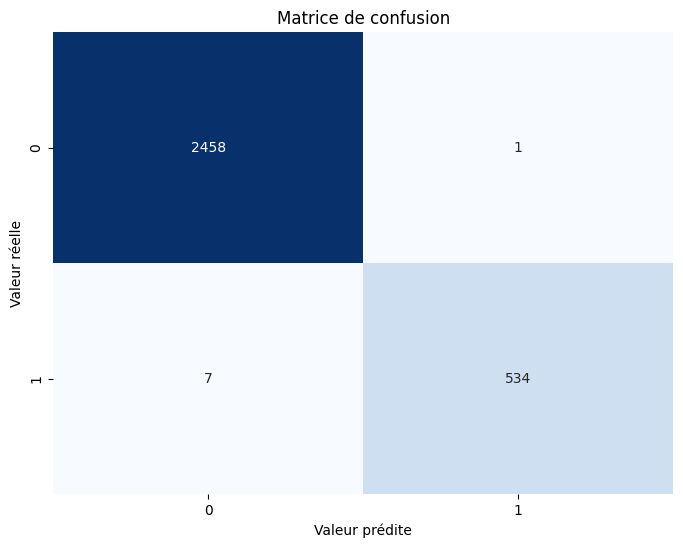

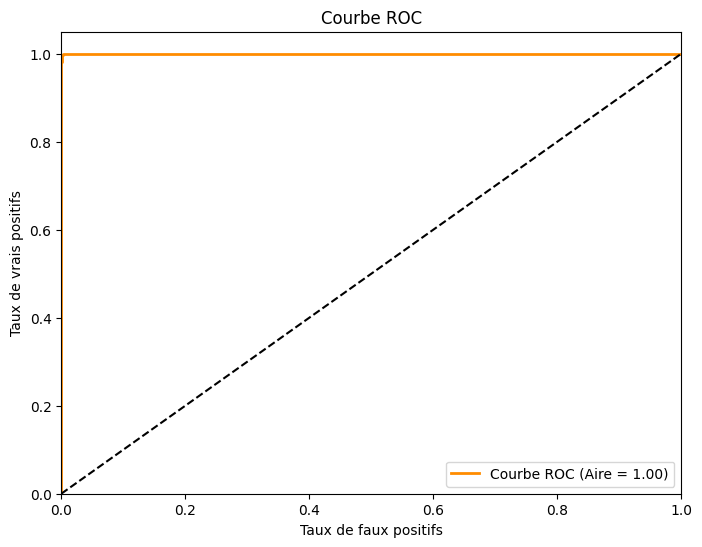

In [6]:
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Initialisation de MLflow
mlflow.set_experiment("prediction_defaut_credit_regression_logistique")

# Définition des paramètres du modèle de régression logistique
params = {
    "solver": "lbfgs",  # Méthode d'optimisation utilisée
    "max_iter": 1000,   # Nombre maximum d'itérations pour la convergence
    "random_state": 42  # Pour garder les résultats reproductibles
}

with mlflow.start_run(run_name="Modèle de Régression Logistique"):

    # Initialisation et entraînement du modèle de régression logistique
    log_reg = LogisticRegression(**params)
    log_reg.fit(X_train, y_train)

    # Prédictions sur l'ensemble de test
    y_pred = log_reg.predict(X_test)
    y_probs = log_reg.predict_proba(X_test)[:, 1]

    # Évaluation du modèle
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    
    # Calcul des métriques supplémentaires
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Log des métriques dans MLflow
    mlflow.log_metric("precision", accuracy)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_param("solveur", params["solver"])
    mlflow.log_param("max_iter", params["max_iter"])
    mlflow.log_param("random_state", params["random_state"])

    # Log du modèle entraîné dans MLflow
    mlflow.sklearn.log_model(log_reg, "modele_regression_logistique")

    # Affichage des résultats
    print(f'\nPrécision: {accuracy}')
    print('\nMatrice de confusion:')
    print(conf_matrix)
    print('\nRapport de classification:')
    print(class_report)

    # Log des graphiques
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Matrice de confusion')
    plt.ylabel('Valeur réelle')
    plt.xlabel('Valeur prédite')
    plt.savefig("matrice_confusion.png")
    mlflow.log_artifact("matrice_confusion.png")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Courbe ROC (Aire = {roc_auc:.2f})', color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC')
    plt.legend(loc="lower right")
    plt.savefig("courbe_roc.png")
    mlflow.log_artifact("courbe_roc.png")

    # Fin de la session MLflow
    mlflow.end_run()

*Interprétation* : <br>
En termes de performance du modèle de régression logistique utilisé, les résultats obtenus sont très satisfants.

 | **Graphique**           | **Interprétation**                                                                                                                                                 |
|-------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Matrice de confusion** | - **2458 vrais négatifs** : le modèle prédit correctement l'absence de défaut.<br> - **1 faux positif** : le modèle a prédit un défaut là où il n'y en avait pas.<br> - **7 faux négatifs** : 7 emprunteurs qui ont fait défaut n'ont pas été détectés.<br> - **534 vrais positifs** : le modèle a correctement identifié les emprunteurs faisant défaut. |
| **Rapport de classification** | - **Précision (classe 0)** : 99,72%, le modèle est très fiable pour prédire l'absence de défaut.<br> - **Précision (classe 1)** : 99,81%, très bonne capacité à détecter les défauts.<br> - **Recall (classe 1)** : 98,71%, une légère baisse dans la détection des emprunteurs en défaut, mais reste très performant.<br> - **Accuracy globale** : 99,73%, performance globale très élevée du modèle. |
| **Courbe ROC**           | - **AUC = 1.00** : Modèle idéal pour distinguer les défauts des non-défauts, ce qui signifie que le modèle est capable de classer parfaitement les emprunteurs à risque et ceux qui ne le sont pas.<br> - **Taux de vrais positifs = 1** : Sensibilité parfaite pour prédire les défauts.<br> - **Taux de faux positifs** : Très faible, avec une seule erreur dans la prédiction des défauts. |

Modèle 2 : RandomForest

2024/09/12 09:52:25 INFO mlflow.tracking.fluent: Experiment with name 'credit_default_prediction' does not exist. Creating a new experiment.
2024/09/12 09:52:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Accuracy: 0.9963333333333333

Confusion Matrix:
[[2456    3]
 [   8  533]]

Classification Report:
{'0': {'precision': 0.9967532467532467, 'recall': 0.9987799918666125, 'f1-score': 0.9977655900873451, 'support': 2459.0}, '1': {'precision': 0.9944029850746269, 'recall': 0.9852125693160814, 'f1-score': 0.989786443825441, 'support': 541.0}, 'accuracy': 0.9963333333333333, 'macro avg': {'precision': 0.9955781159139367, 'recall': 0.9919962805913469, 'f1-score': 0.9937760169563931, 'support': 3000.0}, 'weighted avg': {'precision': 0.9963294162305356, 'recall': 0.9963333333333333, 'f1-score': 0.9963266840447816, 'support': 3000.0}}


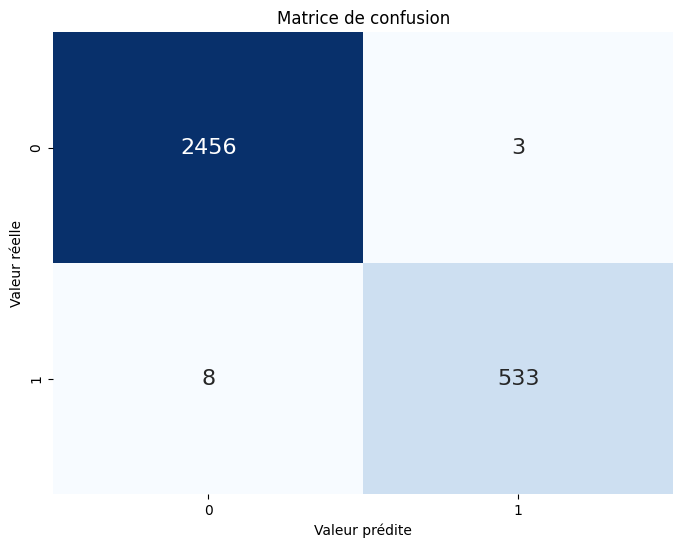

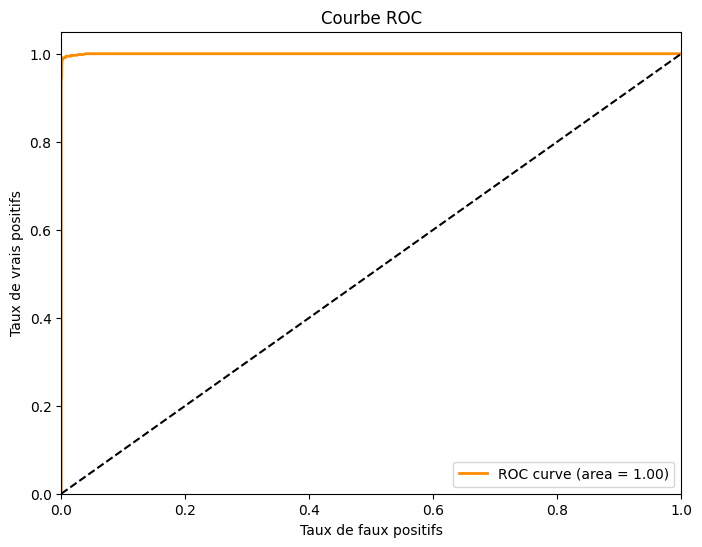

In [7]:
# Préparation des données
X = data[['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score']]
y = data['default']

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Définition des paramètres du modèle
params = {
    "n_estimators": 100,
    "max_depth": None,  # Aucun maximum pour la profondeur des arbres
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "bootstrap": True,
    "random_state": 42
}

# Initialisation de MLflow
mlflow.set_experiment("credit_default_prediction")

with mlflow.start_run(run_name="Random Forest Model"):

    # Initialisation et entraînement du modèle Random Forest
    rf = RandomForestClassifier(**params)
    rf.fit(X_train, y_train)

    # Prédictions sur l'ensemble de test
    y_pred = rf.predict(X_test)
    y_probs = rf.predict_proba(X_test)[:, 1]

    # Evaluation du modèle
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)

    # Calcul de la courbe ROC et  de l'AUC
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Log des métriques dans MLflow
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_param("n_estimators", params["n_estimators"])
    mlflow.log_param("max_depth", params["max_depth"])
    mlflow.log_param("min_samples_split", params["min_samples_split"])
    mlflow.log_param("min_samples_leaf", params["min_samples_leaf"])
    mlflow.log_param("bootstrap", params["bootstrap"])

    # Log du modèle entraîné
    mlflow.sklearn.log_model(rf, "random_forest_model")

    # Affichage des résultats
    print(f'\nAccuracy: {accuracy}')
    print('\nConfusion Matrix:')
    print(conf_matrix)
    print('\nClassification Report:')
    print(class_report)

    # Log de la matrice de confusion comme figure
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
    plt.title('Matrice de confusion')
    plt.ylabel('Valeur réelle')
    plt.xlabel('Valeur prédite')
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Log de la courbe ROC comme figure
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC')
    plt.legend(loc="lower right")
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")

    # Log des graphiques de données
    mlflow.log_artifact("data_histograms.png")
    mlflow.log_artifact("correlation_matrix.png")
    mlflow.log_artifact("fico_score_vs_default.png")
    mlflow.log_artifact("income_vs_debt.png")

    # Fin de la session MLflow
    mlflow.end_run()

*Méthode et interprétation:*
Comme pour la régression logistique, les résultats sont très satisfaisants.

| **Graphique**           | **Interprétation**                                                                                                                                                 |
|-------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Matrice de confusion** | - **2456 vrais négatifs** : Le modèle prédit correctement les clients qui ne font pas défaut.<br> - **3 faux positifs** : Trois erreurs où le modèle a prédit un défaut alors qu'il n'y en a pas eu.<br> - **8 faux négatifs** : Quelques emprunteurs en défaut n'ont pas été détectés.<br> - **533 vrais positifs** : Le modèle identifie correctement les emprunteurs faisant défaut. |
| **Rapport de classification** | - **Précision (classe 0)** : 99,68% — Le modèle est très fiable pour prédire l'absence de défauts.<br> - **Précision (classe 1)** : 99,44% — Bonne capacité à prédire les défauts.<br> - **Recall (classe 1)** : 98,52% — Le modèle rate une petite proportion d'emprunteurs faisant défaut, mais reste performant.<br> - **Précision globale (Accuracy)** : 99,63% — Une performance globale très satisfaisante. |
| **Courbe ROC**           | - **AUC = 1.00** : Le modèle est parfait pour distinguer les emprunteurs en défaut de ceux qui ne le sont pas.<br> - **Taux de vrais positifs = 1** : Sensibilité parfaite pour détecter les défauts.<br> - **Taux de faux positifs** : Très faible, avec seulement 3 erreurs dans la prédiction des défauts. |

**Conclusion:**


| **Modèle**                | **Précision globale (accuracy)** | **Faux positifs** | **Faux négatifs** | **Précision (classe 1)** | **Recall (classe 1)** | **F1-score (classe 1)** | **AUC** |
|---------------------------|----------------------------------|-------------------|-------------------|--------------------------|------------------------|-------------------------|---------|
| **Random Forest**          | 99,63%                           | 3                 | 8                 | 99,44%                   | 98,52%                 | 98,98%                  | 1.00    |
| **Régression logistique**  | 99,73%                           | 1                 | 7                 | 99,81%                   | 98,71%                 | 99,25%                  | 1.00    |

=> Sélection du modèle de régression logistique en raison de ses performances très légérement supérieures à Random Forest pour déploiement sur le cloud

**III. Déploiement du modèle sur le cloud**


1. Création d'une application Streamlit - estimation du risque de défaut de crédit

*Méthode :*
<br><br>
Pour estimer la probabilité de défaut sur les prêts personnels pour chaque client en fonction de ses caractéristiques, nous déployons une application Streamlit (outil de déploiement et suivi de projet en machine learning), basée sur le modèle de régression logistique sélectionné plus haut, en prenant en compte les criètres suivants :
- Nombre de lignes de crédit
- Montant du prêt restant
- Dette totale restante
- Revenu
- Années d'emploi
- Score FICO

=> Pour chaque entrée, l'application réalise une prédiction du risque de défaut de paiement : élevé ou faible.

![WhatsApp Image 2024-09-08 à 20.25.39_2590b842.jpg](<attachment:WhatsApp Image 2024-09-08 à 20.25.39_2590b842.jpg>)
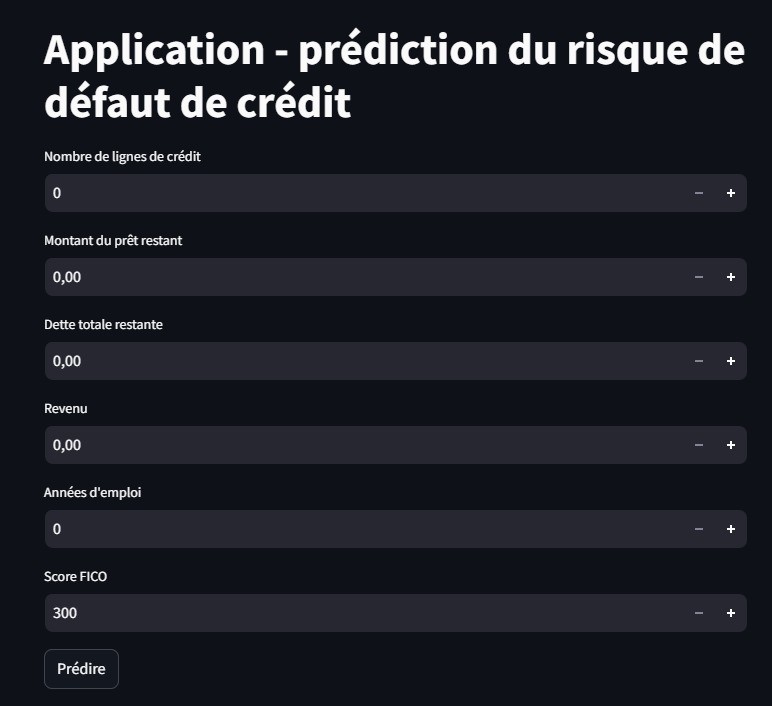